<a href="https://colab.research.google.com/github/ShaunakSen/Data-Science-and-Machine-Learning/blob/master/Parameter_Tuning_with_Hyperopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Parameter Tuning with Hyperopt

[tutorial link](https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt)

There are two common methods of parameter tuning: grid search and random search. Each have their pros and cons. Grid search is slow but effective at searching the whole search space, while random search is fast, but could miss important points in the search space. Luckily, a third option exists: Bayesian optimization. In this post, we will focus on one implementation of Bayesian optimization, a Python module called hyperopt.

Using Bayesian optimization for parameter tuning allows us to obtain the best parameters for a given model, e.g., logistic regression. This also allows us to perform optimal model selection. Typically, a machine learning engineer or data scientist will perform some form of manual parameter tuning (grid search or random search) for a few models - like decision tree, support vector machine, and k nearest neighbors - then compare the accuracy scores and select the best one for use. This method has the possibility of comparing sub-optimal models. Maybe the data scientist found the optimal parameters for the decision tree, but missed the optimal parameters for SVM. This means their model comparison was flawed. K nearest neighbors may beat SVM every time if the SVM parameters are poorly tuned. Bayesian optimization allow the data scientist to find the best parameters for all models, and therefore compare the best models. This results in better model selection, because you are comparing the best k nearest neighbors to the best decision tree.

### Objective Functions - A Motivating Example

Suppose you have a function defined over some range, and you want to minimize it. That is, you want to find the input value that result in the lowest output value. The trivial example below finds the value of x that minimizes a linear function y(x) = x.

In [0]:
import hyperopt

In [5]:
best = hyperopt.fmin(
    fn=lambda x:x,
    space = hyperopt.hp.uniform('x', 0, 1),
    algo = hyperopt.tpe.suggest,
    max_evals = 100
)

print (best)

100%|██████████| 100/100 [00:00<00:00, 425.62it/s, best loss: 0.0005860873247447989]
{'x': 0.0005860873247447989}


Let's break this down.

The function fmin first takes a function to minimize, denoted fn, which we here specify with an anonymous function lambda x: x. This function could be any valid value-returning function, such as mean absolute error in regression.

The next parameter specifies the search space, and in this example it is the continuous range of numbers between 0 and 1, specified by hp.uniform('x', 0, 1). hp.uniform is a built-in hyperopt function that takes three parameters: the name, x, and the lower and upper bound of the range, 0 and 1.

The parameter algo takes a search algorithm, in this case tpe which stands for tree of Parzen estimators. This topic is beyond the scope of this blog post, but the mathochistic reader may peruse this for details. The algo parameter can also be set to hyperopt.random, but we do not cover that here as it is widely known search strategy. However, in a future post, we can.

Finally, we specify the maximum number of evaluations max_evals the fmin function will perform. This fmin function returns a python dictionary of values.

An example of the output for the function above is {'x': 0.000269455723739237}.

Here is the plot of the function. The red dot is the point we are trying to find.

![](https://silvrback.s3.amazonaws.com/uploads/403df379-e565-4f7f-81a4-911c8f77ae28/ex1_large.png)

#### More Complicated Examples
Here is a more complicated objective function: `lambda x: (x-1)**2`. This time we are trying to minimize a quadratic equation `y(x) = (x-1)**2`. So we alter the search space to include what we know to be the optimal value (x=1) plus some sub-optimal ranges on either side: hp.uniform('x', -2, 2).

In [10]:
best = hyperopt.fmin(
    fn = lambda x: (x-1)**2,
    space= hyperopt.hp.uniform('x', -5, 5),
    algo = hyperopt.tpe.suggest,
    max_evals = 1000
)

print (best)

100%|██████████| 1000/1000 [00:04<00:00, 214.87it/s, best loss: 2.448635558780595e-07]
{'x': 1.0004948368982585}


Here is the plot.

![](https://silvrback.s3.amazonaws.com/uploads/7499c5c5-5bd6-4bdb-8030-f82258f686ef/ex2_large.png)

Instead of minimizing an objective function, maybe we want to maximize it. To to this we need only return the negative of the function. For example, we could have a function `y(x) = -(x**2):`

![](https://silvrback.s3.amazonaws.com/uploads/04d36416-60fe-46a3-9cf4-7645b7059989/ex3_large.png)

How could we go about solving this? We just take the objective function `lambda x: -(x**2) and return the negative, giving lambda x: -1*-(x**2) or just lambda x: (x**2).`

Here is a function with many (infinitely many given an infinite range) local minima, which we are also trying to maximize:

![](https://silvrback.s3.amazonaws.com/uploads/661ff1fe-740b-4112-86dc-7f583184d143/ex5_large.png)


### Search Spaces


The hyperopt module includes a few handy functions to specify ranges for input parameters. We have already seen hp.uniform. Initially, these are stochastic search spaces, but as hyperopt learns more (as it gets more feedback from the objective function), it adapts and samples different parts of the initial search space that it thinks will give it the most meaningful feedback.

The following will be used in this post:

- hp.choice(label, options) where options should be a python list or tuple.
- hp.normal(label, mu, sigma) where mu and sigma are the mean and standard deviation, respectively.
- hp.uniform(label, low, high) where low and high are the lower and upper bounds on the range.

To see some draws from the search space, we should import another function, and define the search space.



In [21]:
import hyperopt.pyll.stochastic

space = {
    'x': hyperopt.hp.uniform('x', 0, 1),
    'y': hyperopt.hp.normal('y', 0, 1),
    'name': hyperopt.hp.choice('name', ['alice', 'bob']),
}


# Try running this a few times and to see the different samples.

print (hyperopt.pyll.stochastic.sample(space))


{'name': 'bob', 'x': 0.09423803910588446, 'y': -0.9555273175589711}


### Capturing Info with Trials

It would be nice to see exactly what is happening inside the hyperopt black box. The Trials object allows us to do just that. We need only import a few more items.



In [29]:
fspace = {
    'x': hyperopt.hp.uniform('x', -5, 5)
}

def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': hyperopt.STATUS_OK}

trials = hyperopt.Trials()

best = hyperopt.fmin(fn=f, space=fspace, algo=hyperopt.tpe.suggest, max_evals=10, trials=trials)

print (best)

print ('trials:')
for trial in trials.trials[:10]:
    print (trial)

100%|██████████| 10/10 [00:00<00:00, 787.68it/s, best loss: 1.7057501931694494]
{'x': 1.3060437179395832}
trials:
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 10.495759272532467, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [3.23971592466569]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 10, 22, 11, 13, 26, 725000), 'refresh_time': datetime.datetime(2019, 10, 22, 11, 13, 26, 726000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 7.39795888552516, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [1]}, 'vals': {'x': [-2.7199189115716593]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 10, 22, 11, 13, 26, 727000), 'refresh_time': datetime.datetime(2019, 10, 22, 11, 13, 26, 728000)}
{'state': 2, 'tid': 2, 'spec': None, 'result': {'loss':

The trials object stores data as a BSON object, which works just like a JSON object. BSON is from the pymongo module. We will not discuss the details here, but there are advanced options for hyperopt that require distributed computing using MongoDB, hence the pymongo import.

Back to the output above. The 'tid' is the time id, that is, the time step, which goes from 0 to max_evals-1. It increases by one each iteration. 'x' is in the 'vals' key, which is where your parameters are stored for each iteration. 'loss' is in the 'result' key, which gives us the value for our objective function at that iteration.

Let's look at this in another way.

> If we look at the results, the best is: `{'x': 1.3060437179395832}`
So the loss is lowest and we can see this in the trials data - the lowest loss occurs for that particular x value

In [33]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

fspace = {
    'x': hp.uniform('x', -5, 5)
}

def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=10000, trials=trials)

print ('best:', best)

print ('trials:')
for trial in trials.trials[:2]:
    print (trial)

100%|██████████| 10000/10000 [06:11<00:00, 13.71it/s, best loss: 6.411478772166944e-10]
best: {'x': -2.532089803337738e-05}
trials:
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 16.125300794288993, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [-4.015632054146519]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 10, 22, 11, 22, 1, 350000), 'refresh_time': datetime.datetime(2019, 10, 22, 11, 22, 1, 350000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 3.724093570007394, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [1]}, 'vals': {'x': [1.9297910690039464]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 10, 22, 11, 22, 1, 355000), 'refresh_time': datetime.datetime(2019, 10, 22, 11, 22, 1, 355000)}


### Visualization

We'll go over two types of visualizations here: val vs. time, and loss vs. val. First, val vs. time. Below is the code and sample output for plotting the trials.trials data described above.



Text(0, 0.5, '$x$')

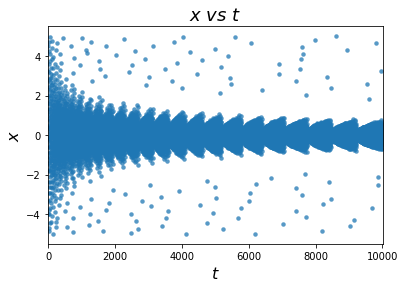

In [34]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['x'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

We can see that initially the algorithm picks values from the whole range equally (uniformly), but as time goes on and more is learned about the parameter's effect on the objective function, the algorithm focuses more and more on areas in which it thinks it will gain the most - the range close to zero. It still explores the whole solution space, but less frequently.

Now let's look at the plot of loss/val vs. x.



Text(0, 0.5, '$val$')

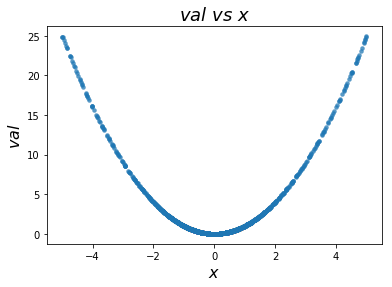

In [35]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$val$ $vs$ $x$ ', fontsize=18)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$val$', fontsize=16)

### The Iris Dataset

In this section, we'll walk through 4 full examples of using hyperopt for parameter tuning on a classic dataset, Iris. We will cover K-Nearest Neighbors (KNN), Support Vector Machines (SVM), Decision Trees, and Random Forests. Note that since we are trying to maximize the cross-validation accuracy (acc in the code below), we must negate this value for hyperopt, since hyperopt only knows how to minimize a function. Minimizing a function f is the same as maximizing the negative of f.

For this task, we'll use the classic Iris data set, and do some supervised machine learning. There are 4 input features, and three output classes. The data are labeled as belonging to class 0, 1, or 2, which map to different kinds of Iris flower. The input has 4 columns: sepal length, sepal width, petal length, and pedal width. Units of the input are centimeters. We will use these 4 features to learn a model that predicts one of three output classes. Since the data is provided by sklearn, it has a nice DESCR attribute that provides details on the data set. Try the following for more details.



In [38]:
from sklearn.datasets import load_iris

iris = load_iris()

print (iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [39]:
print (iris.feature_names)

print (iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [43]:
import seaborn as sns
import pandas as pd 

sns.set(style="whitegrid", palette="husl")

iris = sns.load_dataset("iris")
print (iris.head())

iris = pd.melt(iris, "species", var_name="measurement")
print (iris.head())


   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
  species   measurement  value
0  setosa  sepal_length    5.1
1  setosa  sepal_length    4.9
2  setosa  sepal_length    4.7
3  setosa  sepal_length    4.6
4  setosa  sepal_length    5.0


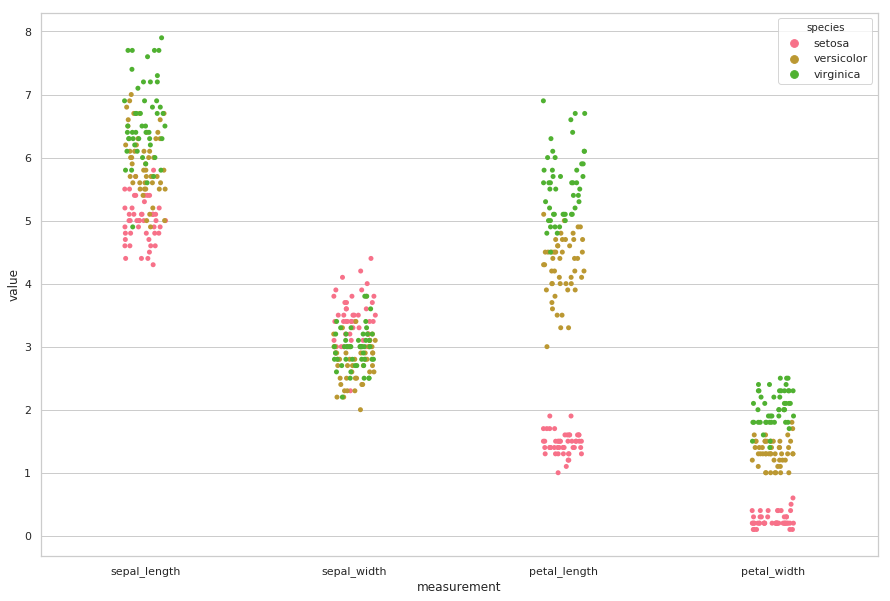

In [45]:

f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax);

### K-Nearest Neighbors

We now apply hyperopt to finding the best parameters to a K-Nearest Neighbor (KNN) machine learning model. The KNN model classifies a data point from the test set based on majority class of the k nearest data points in the training data set.

In [48]:
iris = load_iris()
X = iris.data
y = iris.target

print (X.shape, y.shape)

(150, 4) (150,)


In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


clf = KNeighborsClassifier(**params)

scores = cross_val_score(clf, X, y)

print (scores)

[0.98039216 0.98039216 1.        ]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [72]:
fspace = {
    'x': hp.uniform('x', -5, 5)
}

def f(params):
    x = params['x']
    print ('trying for x=:',x)
    val = x**2
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=10, trials=trials)

print ('best:', best)

print ('trials:')
for trial in trials.trials:
    print (trial)

trying for x=:
0.9717752815361802
trying for x=:
3.2596363780455313
trying for x=:
4.683054552519071
trying for x=:
2.8344033046948898
trying for x=:
4.144632966510995
trying for x=:
0.9761518997015877
trying for x=:
-0.7747308580390557
trying for x=:
-2.2128550149868476
trying for x=:
-1.306684653842245
trying for x=:
-3.7698599757864324
100%|██████████| 10/10 [00:00<00:00, 69.79it/s, best loss: 0.6002079023979315]
best: {'x': -0.7747308580390557}
trials:
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.9443471978047223, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [0.9717752815361802]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 10, 22, 13, 0, 29, 431000), 'refresh_time': datetime.datetime(2019, 10, 22, 13, 0, 29, 446000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 10.62522931707779, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('doma

In [94]:
-0.7747308580390557**2

-0.6002079023979315

How hyperopt works is for values in the space, it will run the fn and see the loss. It will do this max_eval times and each time it will select a value from the space according to the algo specified.


At the end it will return the best loss and if we are using hp.choice it will return the index of the best param


In [115]:
def hyperopt_train_test(params):
  clf = KNeighborsClassifier(**params)
  accuracy = cross_val_score(estimator=clf, X=X, y=y, cv=3).mean()
  print ('Param selected:', params, 'accuracy:', accuracy)
  if params['n_neighbors'] == 5:
    print ('here')
    return 0.8
  else:
    return accuracy

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', list(range(1,10)))
}


def f(params):
  acc = hyperopt_train_test(params)
  return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=f,
    space = space4knn,
    algo = tpe.suggest,
    max_evals = 20,
    trials = trials
)

print (best)

Param selected:
{'n_neighbors': 7}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 8}
accuracy:
0.9799836601307189
Param selected:
{'n_neighbors': 6}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 2}
accuracy:
0.9534313725490197
Param selected:
{'n_neighbors': 8}
accuracy:
0.9799836601307189
Param selected:
{'n_neighbors': 6}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 2}
accuracy:
0.9534313725490197
Param selected:
{'n_neighbors': 2}
accuracy:
0.9534313725490197
Param selected:
{'n_neighbors': 6}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 3}
accuracy:
0.9803921568627452
Param selected:
{'n_neighbors': 7}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 7}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 4}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 1}
accuracy:
0.9673202614379085
Param selected:
{'n_neighbors': 7}
accuracy:
0.9734477124183006
Param selected:
{'n_neighbors': 3}
accur

In [116]:
for trial in trials.trials:
  print (trial)

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.9734477124183006, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'n_neighbors': [0]}, 'vals': {'n_neighbors': [6]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 10, 22, 14, 32, 27, 725000), 'refresh_time': datetime.datetime(2019, 10, 22, 14, 32, 27, 784000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': -0.9799836601307189, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'n_neighbors': [1]}, 'vals': {'n_neighbors': [7]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 10, 22, 14, 32, 27, 786000), 'refresh_time': datetime.datetime(2019, 10, 22, 14, 32, 27, 828000)}
{'state': 2, 'tid': 2, 'spec': None, 'result': {'loss': -0.9734477124183006, 'status': 'ok'}, 'misc': {'tid': 2, 'cmd': ('domain_attachment', 'FMinIter_Domain

In [118]:
list(range(1,10))[6]

7

## NOTE: For hp.choice the answer is the INDEX NOT the ACTUAL value

[link](https://github.com/hyperopt/hyperopt/issues/431)

[link](https://github.com/hyperopt/hyperopt/issues/384)

In [105]:
from sklearn.metrics import accuracy_score
clf = KNeighborsClassifier(n_neighbors=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print (X_train.shape, X_test.shape)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print (accuracy_score(y_test, y_pred))

(105, 4) (45, 4)
0.28888888888888886


### Try with train_test split

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

100%|██████████| 100/100 [00:01<00:00, 87.62it/s, best loss: -1.0]
best:
{'n_neighbors': 37}


### Original code

In [139]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y, cv=3).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,20))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

100%|██████████| 100/100 [00:01<00:00, 72.00it/s, best loss: -0.9869281045751634]
best:
{'n_neighbors': 4}


Now let's see the plot of the output. The y axis is the cross validation score, and the x axis is the k value in k-nearest-neighbors. Here is the code and its image:



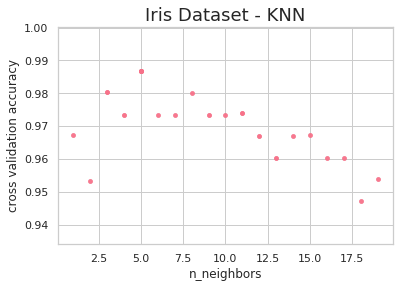

In [137]:
f, ax = plt.subplots(1)#, figsize=(10,10))

xs = []
ys = []

for t in trials.trials:
  n_idx = t['misc']['vals']['n_neighbors'][0]
  n_selected = list(range(1,20))[n_idx]#
  xs.append(n_selected)
  acc = -t['result']['loss']
  ys.append(acc)

ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12);

We find the best value at `{'n_neighbors': 4}` i.e at index 4 that means the **value of n_neighbors is 5**

### Support Vector Machines (SVM)




In [148]:
from sklearn.svm import SVC

def hyperopt_train_test(params):
  clf = SVC(**params)
  return cross_val_score(clf, X, y, cv=3).mean()

space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20)
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=200, trials=trials)
print ('best:')
print (best)

100%|██████████| 200/200 [00:07<00:00, 25.23it/s, best loss: -0.9869281045751634]
best:
{'C': 7.750992063377014, 'gamma': 2.1681543626110122, 'kernel': 3}
